In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.integrate import quad
from scipy.stats import gamma
import scipy.special as sc
from MessagePassing import *

In [2]:
def draw_graph(G):
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

    pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
    )

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def find_next_child(G, source_node):
    child_node = None
    max_weight = 0
    for node in source_node:
        for neighbor in G.neighbors(node):
            #print(f"neighbor is {neighbor}")
            if neighbor not in source_node:
                weight = G[node][neighbor]['weight']
                if weight > max_weight:
                    max_weight = weight
                    child_node = neighbor
                    #print(f"child node is {child_node}")
    return child_node

def find_parents(i, G, source=['s']):
    parent_node = []
    # First get all the neighbors of node i
    candidate = G.neighbors(i)
    for n in candidate:
        # Find the nodes in the source set
        if n in source:
            parent_node.append(n)
    return parent_node

# We use theta instead of r in the paper.
def compute_ccdf(x, k, theta):
    return 1 - gamma.cdf(x, k, scale=theta)

I = ['s']
def product_ccdf(t, j, k, theta):
    v = 1
    for par in find_parents(j, G, source=I):
        v *= compute_ccdf(t, k[par], theta[par])
    return v

def integrand_moment(t, j, k, theta, p):
    return p * t**(p - 1) * product_ccdf(t, j, k, theta)

def compute_moment(j, k, theta, p):
    return quad(integrand_moment, 0, np.inf, args=(j, k, theta, p))[0]

# Calculate k and r for node a
def compute_theta(E, V, lambda_p):
    return (E + 1/lambda_p) / (V + 1/lambda_p**2)

def compute_k(E, V, lambda_p):
    return (E + 1/lambda_p)**2 / (V + 1/lambda_p**2)

def compute_expectation(k1, r1, k2, r2):
  beta_top = sc.betainc(k2+1, k1, r2/(r1+r2))
  beta_down = sc.betainc(k2, k1, r2/(r1+r2))
  expectation = (k1+k2) / r1 - k2*(r1+r2) / (r1*r2) * (beta_top / beta_down)
  return 1/expectation

Considering a simple circle graph with equal weight, we can simply choose any of the nodes as the source node by symmetry.

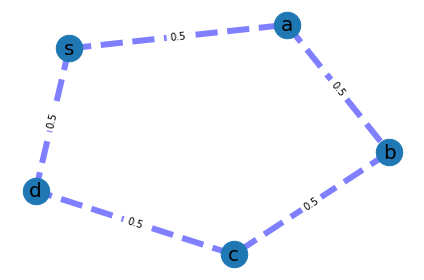

In [3]:
G = nx.Graph()
G.add_nodes_from(['s', 'a', 'b', 'c', 'd'])
G.add_edge('s', 'a', weight=0.5)
G.add_edge('a', 'b', weight=0.5)
G.add_edge('b', 'c', weight=0.5)
G.add_edge('c', 'd', weight=0.5)
G.add_edge('d', 's', weight=0.5)

draw_graph(G)

0.6666666666666666 2.6666666666666665
['s', 'a']
0.3347430059555463


<ipython-input-2-22b67f8f139a>:67: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrand_moment, 0, np.inf, args=(j, k, theta, p))[0]


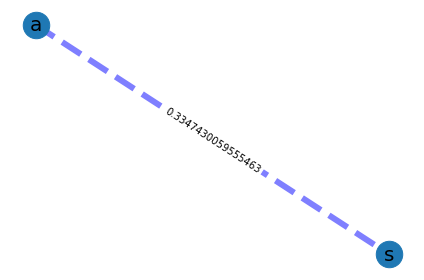

In [4]:
lambda_sa = G.get_edge_data('s', 'a')['weight']
#print(lambda_sa)

# Assume k and r are both 1 for node s with expectation and variance are 1.
theta_s = 1
k_s = 2
E_s = k_s/theta_s
V_s = k_s/theta_s**2

theta_a = compute_theta(E_s, V_s, lambda_sa)
k_a = compute_k(E_s, V_s, lambda_sa)

print(theta_a, k_a)

j = 'a'
k = {'s': k_s}
theta = {'s': theta_s}

moment_1 = compute_moment('s', k, theta, 1)
moment_2 = compute_moment('s', k, theta, 2)

lambda_sa_1 = compute_expectation(k_a, theta_a, k_s, theta_s)

T = nx.Graph()
T.add_edge('a', 's', weight=lambda_sa_1)
I.append('a')
print(I)

print(lambda_sa_1)
draw_graph(T)

In [5]:
next_node = find_next_child(G, I)
parents = find_parents(next_node, G, source=I)
print(next_node)
print(parents)

d
['s']


In [6]:
lambda_1 = G.get_edge_data(parents[0], next_node)['weight']

# For node s, we now compute the k and r
k_sd = compute_k(E_s, V_s, lambda_1)
theta_sd = compute_theta(E_s, V_s, lambda_1)
print(k_sd, theta_sd)

k_1 = {'s': k_s, 'a': k_a, 'd': k_sd}
theta_1 = {'s': theta_s, 'a': theta_a, 'd': theta_sd}

E_a = moment_1
V_a = moment_2 - moment_1**2

moment_1_sd = compute_moment('s', k_1, theta_1, 1)
moment_2_sd = compute_moment('s', k_1, theta_1, 2)

lambda_sd_1 = compute_expectation(k_sd, theta_sd, k_s, theta_s)
print(lambda_sd_1)

2.6666666666666665 0.6666666666666666
0.3347430059555463


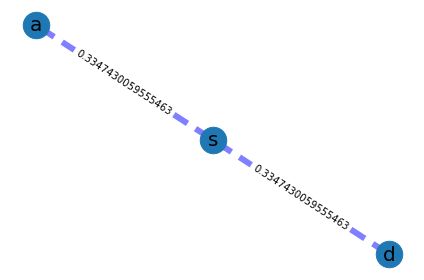

In [8]:
I.append(next_node)
T.add_edge('s', next_node, weight=lambda_sd_1)

draw_graph(T)

In [9]:
j = find_next_child(G, I)
print(j)
parents = find_parents(j, G, source=I)
print(parents)

lambda_2 = G.get_edge_data(parents[0], j)['weight']

k_ab = compute_k(E_a, V_a, lambda_2)
theta_ab = compute_theta(E_a, V_a, lambda_2)
print(k_ab, theta_ab)

k_1 = {'s': k_s, 'a': k_a, 'd': k_sd, 'b': k_ab}
theta_1 = {'s': theta_s, 'a': theta_a, 'd': theta_sd, 'b': theta_ab}

moment_1_ab = compute_moment('a', k_1, theta_1, 1)
moment_2_ab = compute_moment('a', k_1, theta_1, 2)

lambda_ab_1 = compute_expectation(k_ab, theta_ab, k_a, theta_a)
print(lambda_ab_1)

b
['a']
0.2500000007898132 0.2500000007898132
0.3749882609052174


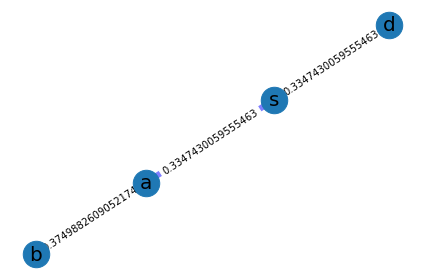

In [10]:
I.append(j)
T.add_edge('a', j, weight=lambda_ab_1)

draw_graph(T)

In [11]:
j = find_next_child(G, I)
print(j)
parents = find_parents(j, G, source=I)
print(parents)

lambda_1 = G.get_edge_data(parents[0], j)['weight']
lambda_2 = G.get_edge_data(parents[1], j)['weight']

E_b = moment_1_ab
V_b = moment_2_ab - moment_1_ab**2

k_bc = compute_k(E_b, V_b, lambda_1)
theta_bc = compute_theta(E_b, V_b, lambda_1)
print(k_bc, theta_bc)

k_dc = compute_k(E_b, V_b, lambda_2)
theta_dc = compute_theta(E_b, V_b, lambda_2)
print(k_dc, theta_dc)

k_1 = {'s': k_s, 'a': k_a, 'd': k_sd, 'b': k_ab}
theta_1 = {'s': theta_s, 'a': theta_a, 'd': theta_sd, 'b': theta_ab}

moment_1_bc = compute_moment('b', k_1, theta_1, 1)
moment_2_bc = compute_moment('b', k_1, theta_1, 2)
moment_1_dc = compute_moment('d', k_1, theta_1, 1)
moment_2_dc = compute_moment('d', k_1, theta_1, 2)

print(moment_1_bc, moment_1_dc)
# lambda_ab_1 = compute_expectation(k_ab, theta_ab, k_a, theta_a)
# print(lambda_ab_1)

c
['b', 'd']
2.666666666666664 0.666666666666666
2.666666666666664 0.666666666666666
1.7777777777808363 1.9999999999999996


0.27444993818698665


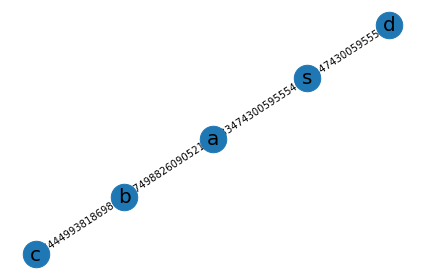

In [12]:
lambda_bc_1 = compute_expectation(k_bc, theta_bc, k_ab, theta_ab)
print(lambda_bc_1)

I.append(j)
T.add_edge('b', j, weight=lambda_bc_1)
draw_graph(T)

In [13]:
next_node = find_next_child(G, I)
print(next_node)

None


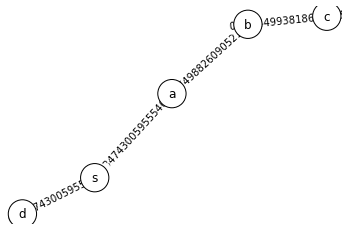

The most likely source nodes are: {'a'} 
 the corresponding likelyhood probability value is 4.2694292326563605 
 the index of the ovservation time correspond to node a  is  10


interactive(children=(IntSlider(value=1, description='index of the observation time', layout=Layout(width='500…

the darker the node color, the larger probability for the node to be the source


In [14]:
MP_weighted(T, T.nodes(), T_max=5, num_T_positions=10)